[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MBanuelos/grad-numerical/blob/main/week14_advection_fv.ipynb)

# Week 14 – Finite Volume Methods for Linear Advection

## Learning Objectives

By the end of this notebook, students should be able to:

- Derive a finite volume scheme from the integral (conservative) form of a PDE.
- Define and interpret numerical fluxes across cell interfaces.
- Implement first-order upwind and Lax–Friedrichs finite volume schemes for linear advection.
- Compare mass conservation and numerical diffusion for different schemes.
- Relate finite volume methods to finite difference schemes from Week 13.


## 1. Conservation Form of the Linear Advection Equation

We again consider the 1D linear advection equation:
$$u_t + c\,u_x = 0.$$

This can be written in conservation form:
$$u_t + \partial_x F(u) = 0, \quad F(u) = c\,u.$$

We partition the domain into cells:
$$
C_j = [x_{j-1/2}, x_{j+1/2}], \quad j = 0,1,\dots,N-1,
$$
with cell centers at $x_j$ and cell width $\Delta x$.

Define the cell average:
$$
\bar u_j(t) = \frac{1}{\Delta x}\int_{C_j} u(x,t)\,dx.
$$

Integrating the conservation law over cell $C_j$ gives
$$
\frac{d}{dt}\bar u_j(t)
= -\frac{1}{\Delta x} \big(F(u(x_{j+1/2},t)) - F(u(x_{j-1/2},t))\big).
$$

To discretize, we approximate the fluxes at the interfaces $x_{j\pm 1/2}$.


## 2. Numerical Fluxes

We cannot evaluate $F(u(x_{j+1/2},t))$ exactly, so we approximate it with a numerical flux:
$$\hat F_{j+1/2} = \hat F(\bar u_j, \bar u_{j+1}).$$

A general finite volume update is then
$$
\bar u_j^{n+1}
= \bar u_j^n - \frac{\Delta t}{\Delta x}
\big(\hat F_{j+1/2}^n - \hat F_{j-1/2}^n\big).
$$

The choice of $\hat F$ determines the scheme.

### Two Important Choices for Linear Advection

For $F(u) = c u$, some common numerical fluxes are:

1. **Upwind flux** (for $c>0$):
   $$\hat F_{j+1/2} = c\,\bar u_j.$$
   Information comes from the upwind cell.

2. **Lax–Friedrichs flux**:
   $$
   \hat F_{j+1/2} = \tfrac{1}{2}\big(F(\bar u_j) + F(\bar u_{j+1})\big)
   - \tfrac{\alpha}{2}(\bar u_{j+1} - \bar u_j),
   $$
   where $\alpha$ is a dissipation parameter, typically chosen as an upper bound on $|F'(u)|$.  
   For linear advection, $F'(u)=c$, so we can take $\alpha = |c|$.


## 3. Grid, Initial Condition, and Periodic Boundaries

We will again use:

- Domain: $x \in [0,1]$
- $N$ cells with width $\Delta x = 1/N$
- Periodic boundary conditions
- Initial condition: Gaussian bump

We interpret the discrete values as cell averages rather than point values.


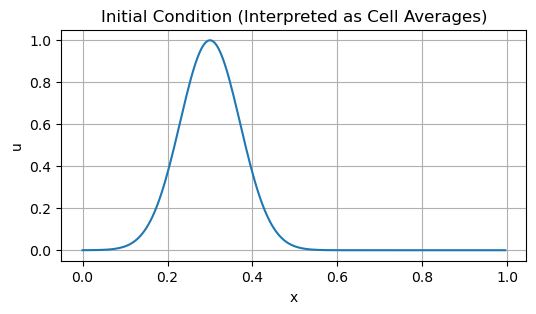

dx = 0.0050, dt = 0.0040, nt = 125


In [3]:
import numpy as np
import matplotlib.pyplot as plt

L = 1.0
N = 200
dx = L / N
x_cell_centers = np.linspace(0, L, N, endpoint=False)

c = 1.0
Tfinal = 0.5

lambda_target = 0.8
dt = lambda_target * dx / c
nt = int(Tfinal / dt)

def initial_condition(x):
    return np.exp(-100.0 * (x - 0.3)**2)

u0 = initial_condition(x_cell_centers)

plt.figure(figsize=(6, 3))
plt.plot(x_cell_centers, u0)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Initial Condition (Interpreted as Cell Averages)")
plt.grid(True)
plt.show()

print(f"dx = {dx:.4f}, dt = {dt:.4f}, nt = {nt}")

## 4. Upwind Finite Volume Scheme

For $c>0$, the upwind numerical flux is
$$\hat F_{j+1/2} = c\,\bar u_j.$$

Then the FV update becomes:
$$
\bar u_j^{n+1}
= \bar u_j^n - \frac{\Delta t}{\Delta x}
\big(c\,\bar u_j^n - c\,\bar u_{j-1}^n\big).
$$

This is exactly the FTBS scheme from Week 13, but now interpreted as a flux difference.

We implement this scheme with periodic boundaries.


In [15]:
def fv_upwind(u0, c, dx, dt, nt):
    '''
    Finite volume upwind scheme for u_t + c u_x = 0 with c > 0.
    Periodic boundary conditions.
    '''
    N = len(u0)
    u = u0.copy()
    history = [u.copy()]
    lambda_c = c * dt / dx
    for n in range(nt):
        # fluxes at interfaces: F_{j+1/2} = c * u_j
        F = ...
        # flux difference: F_{j+1/2} - F_{j-1/2} -> roll for periodicity
        F_plus = ...
        F_minus = ...
        u_new = ...
        u = u_new
        history.append(u.copy())
    return np.array(history)

In [ ]:
history_fv_upwind = fv_upwind(u0, c, dx, dt, nt)

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(x_cell_centers, u0, label="t=0")
plt.plot(x_cell_centers, history_fv_upwind[nt//2], label=f"t={dt*(nt//2):.3f}")
plt.plot(x_cell_centers, history_fv_upwind[-1], label=f"t={dt*nt:.3f}")
plt.xlabel("x")
plt.ylabel("u")
plt.title("Finite Volume Upwind Scheme for Linear Advection")
plt.legend()
plt.grid(True)
plt.show()

### Mass Conservation Check

One of the key advantages of finite volume methods is that they are conservative by construction (up to numerical roundoff). That is, the discrete total mass
$$M^n = \sum_j \bar u_j^n \Delta x$$
should remain (almost) constant in time.


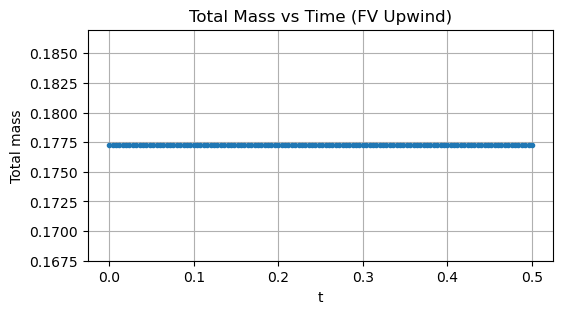

Initial mass: 0.17724372048877107
Final mass: 0.1772437204887711


In [7]:
mass_history = dx * history_fv_upwind.sum(axis=1)

plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, dt*nt, nt+1), mass_history, marker=".")
plt.xlabel("t")
plt.ylabel("Total mass")
plt.title("Total Mass vs Time (FV Upwind)")
plt.grid(True)
plt.show()

print("Initial mass:", mass_history[0])
print("Final mass:", mass_history[-1])

## 5. Lax–Friedrichs Finite Volume Scheme

For linear advection, $F(u) = c u$ and we choose $\alpha = |c|$.  
The Lax–Friedrichs numerical flux is
$$
\hat F_{j+1/2}
= \tfrac{1}{2}\big(c\,\bar u_j + c\,\bar u_{j+1}\big)
- \tfrac{\alpha}{2}(\bar u_{j+1} - \bar u_j)
= \tfrac{c}{2}(\bar u_j + \bar u_{j+1})
- \tfrac{|c|}{2}(\bar u_{j+1} - \bar u_j).
$$

This is more diffusive than the upwind flux but has good stability properties.

We now implement the Lax–Friedrichs FV scheme.


In [17]:
def fv_lax_friedrichs(u0, c, dx, dt, nt):
    '''
    Finite volume Lax–Friedrichs scheme for u_t + c u_x = 0.
    Periodic boundary conditions.
    '''
    N = len(u0)
    u = u0.copy()
    history = [u.copy()]
    alpha = abs(c)
    for n in range(nt):
        u_plus = ...
        # numerical flux at j+1/2 uses (u_j, u_{j+1})
        F_plus_half = ...
        # flux at j-1/2 is roll of that
        F_minus_half = ...
        u_new = ...
        u = u_new
        history.append(u.copy())
    return np.array(history)

In [ ]:
history_fv_lf = fv_lax_friedrichs(u0, c, dx, dt, nt)

plt.figure(figsize=(6, 3))
plt.plot(x_cell_centers, u0, label="t=0")
plt.plot(x_cell_centers, history_fv_lf[nt//2], label=f"t={dt*(nt//2):.3f}")
plt.plot(x_cell_centers, history_fv_lf[-1], label=f"t={dt*nt:.3f}")
plt.xlabel("x")
plt.ylabel("u")
plt.title("Finite Volume Lax–Friedrichs Scheme")
plt.legend()
plt.grid(True)
plt.show()

mass_history_lf = dx * history_fv_lf.sum(axis=1)
print("Initial mass (LF):", mass_history_lf[0])
print("Final mass (LF):", mass_history_lf[-1])

## 6. Exercise 1 – Compare Upwind and Lax–Friedrichs

### Task

1. On the same figure, plot the solutions at final time $T$ for:
   - FV upwind
   - FV Lax–Friedrichs
2. Compare:
   - Shape preservation of the Gaussian bump
   - Amount of numerical diffusion (smoothing)
   - Any spurious oscillations

*Hint:* Reuse `history_fv_upwind` and `history_fv_lf` at index `-1` for final time.


In [ ]:
# Exercise 1: Compare FV Upwind vs FV Lax–Friedrichs at final time

# TODO:
# 1. Create a new figure.
# 2. Plot u0, the final-time upwind solution, and the final-time LF solution.
# 3. Add labels, legend, and a title describing what you see.

## 7. Exercise 2 – Square Wave Initial Condition

Smooth data behaves nicely, but finite volume methods are particularly useful for discontinuous data (for example shocks or contact discontinuities).

### Task

1. Replace the Gaussian initial condition with a square wave:
$$
u_0(x) =
\begin{cases}
1, & 0.2 \le x \le 0.4, \\
0, & \text{otherwise.}
\end{cases}
$$
2. Run both FV upwind and FV Lax–Friedrichs to final time $T$ with the same parameters.
3. Compare how each scheme handles the discontinuity.
   - Which scheme smears out the discontinuity more?
   - Do you see any oscillations near the jump?


In [13]:
# Exercise 2: Square wave initial condition

def square_wave_ic(x):
    return np.where((x >= 0.2) & (x <= 0.4), 1.0, 0.0)

# TODO:
# 1. Set u0_square = square_wave_ic(x_cell_centers)
# 2. Run fv_upwind and fv_lax_friedrichs with this new initial condition.
# 3. Plot the results at final time and compare.


## 8. Connection to Finite Difference Methods

For linear advection with $c>0$, the FV upwind scheme is algebraically identical to the FTBS finite difference scheme from Week 13, but:

- FD view: approximating $u_x$ directly via one-sided differences.
- FV view: approximating flux differences across cell interfaces, enforcing conservation of cell averages.

The FV interpretation generalizes more naturally to complex conservation laws (non-linear fluxes, systems of equations, higher dimensions).


## 9. Summary and Looking Ahead

In this notebook we:

- Derived a finite volume scheme for linear advection from the integral conservation law.
- Introduced numerical fluxes and implemented upwind and Lax–Friedrichs schemes.
- Observed mass conservation and numerical diffusion for both schemes.
- Linked finite volume upwind to the FTBS scheme from Week 13.

**Next (Week 15):** We will take a different perspective and approximate solutions using Fourier/spectral methods, which represent the solution as a sum of global modes and can achieve very high accuracy for smooth solutions.
